In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from copy import deepcopy
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3015,))
])
emnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation((90, 90)),
    transforms.Normalize((0.1722,), (0.3242,))
])
train_mnist_data = datasets.MNIST('./data', train=True, transform=mnist_transform, download=True)
test_mnist_data = datasets.MNIST('./data', train=False, transform=mnist_transform)

train_emnist_data = datasets.EMNIST('./data', train=True, split='letters', transform=emnist_transform, download=True)
test_emnist_data = datasets.EMNIST('./data', train=False, split='letters', transform=emnist_transform)

def get_subsampled_dataset(dataset, samples_per_class=10, num_classes=27):
    all_inds = []
    for target in range(num_classes):
        indices = np.where(dataset.targets == target)[0]
        if len(indices) == 0:
            continue
        subsample = np.arange(0, len(indices), len(indices) / samples_per_class).astype(np.int32)
        subsampled_inds = indices[subsample]
        all_inds.append(subsampled_inds)
    all_inds = np.concatenate(all_inds)
    dataset = torch.utils.data.Subset(dataset, all_inds)
    return dataset

subsample_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
subsampled_emnists = {
    subsample_size: get_subsampled_dataset(train_emnist_data, subsample_size, num_classes=27) 
                    for subsample_size in subsample_sizes
}
subsampled_mnists = {
    subsample_size: get_subsampled_dataset(train_mnist_data, subsample_size, num_classes=10) 
                    for subsample_size in subsample_sizes
}

def get_new_data_loader(dataset, batch_size=8):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return iter(loader)

# Assert that we get a balanced subsampling of classes
# example_loader = get_new_data_loader(subsampled_mnists[16], batch_size=8)
# labels = np.zeros(27)
# for i, (data, target) in enumerate(example_loader):
#     for t in target:
#         labels[t] += 1
# print(labels)

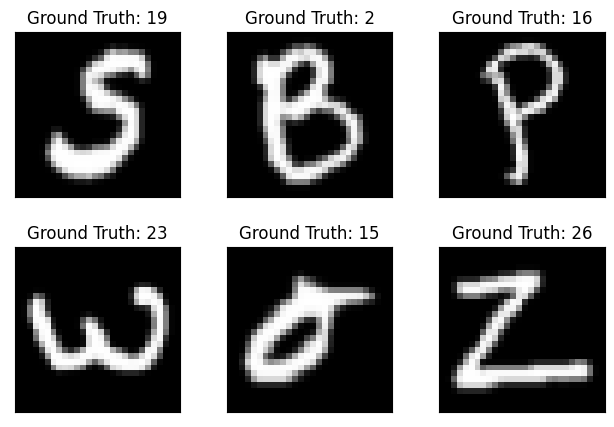

In [3]:
def plot_images(data_loader, batch_size, augmentation=None, transform=None, retain_original=None):
    train_generator = enumerate(data_loader)
    batch_idx, (samples, targets) = next(train_generator)
    if augmentation is not None:
        samples, _ = augment(augmentation, samples, targets, transform=transform, retain_original=retain_original)
    fig = plt.figure()
    if not retain_original:
        r = 6
    else:
        r = 3
    for i in range(r):
        plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.imshow(samples[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(targets[i]))
        if retain_original:
            plt.subplot(2, 3, i+4)
            plt.imshow(samples[i + batch_size][0], cmap='gray', interpolation='none')
            plt.title("Augmented")
        plt.xticks([])
        plt.yticks([])
    plt.show()
    plt.close()
    
batch_size = 8
data_vis_loader = get_new_data_loader(train_emnist_data)
plot_images(data_vis_loader, batch_size=batch_size)

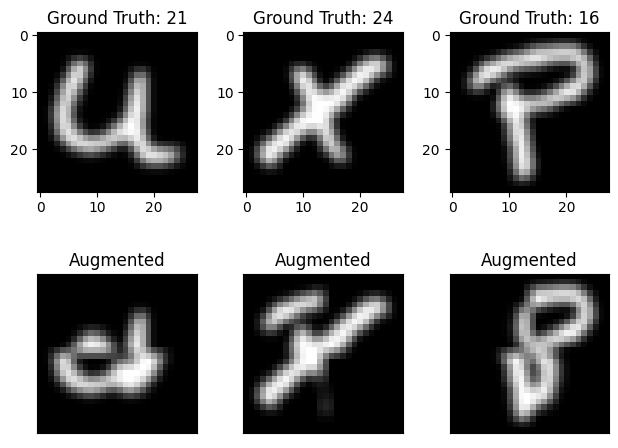

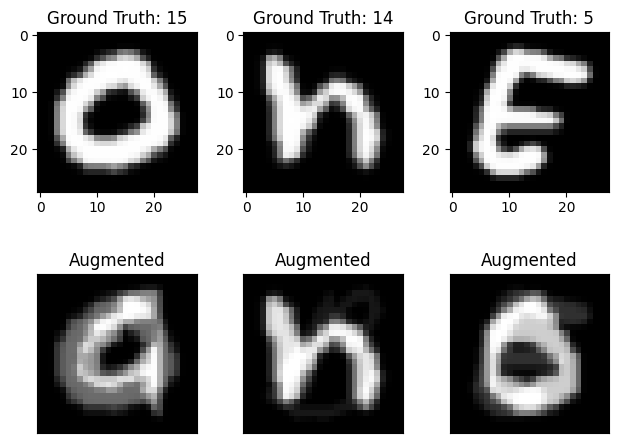

In [4]:
def onehot(labels, num_classes):
    onehot_labels = np.zeros((len(labels), num_classes))
    onehot_labels[np.arange(len(labels)), labels] = 1
    return onehot_labels

# Take top-left and bottom-right quarters from one image and top-right and bottom-left quarters from another
def collage(batch, i, j):
    im_size = int(batch.shape[2])
    assert im_size == int(batch.shape[3])
    
    result = np.copy(batch[i])
    interpolation = 0.5
    result[:, :int(im_size/2), :int(im_size/2)] = batch[j, :, :int(im_size/2), :int(im_size/2)]
    result[:, int(im_size/2):, int(im_size/2):] = batch[j, :, int(im_size/2):, int(im_size/2):]
    return result, interpolation

# Linearly interpolate between two images
def mixup(batch, i, j, alpha=0.3):
    interpolation = np.random.beta(alpha, alpha)
    result = interpolation * batch[i] + (1 - interpolation) * batch[j]
    return result, interpolation

def augment(augmentation, batch, labels, transform=None, retain_original=True, num_classes=10):
    batch_size = len(batch)
    new_batch = np.zeros_like(batch)
    merge_indices = np.zeros(batch_size, dtype=np.int32)
    interpolations = np.zeros(batch_size)
    for i, image in enumerate(batch):
        merge_indices[i] = np.random.choice(np.delete(np.arange(batch_size), i))        
        new_batch[i], interpolations[i] = augmentation(batch, i, merge_indices[i])
        
    if retain_original:
        images = torch.cat([batch, torch.tensor(new_batch)], axis=0)
        labels = torch.tensor(
            np.concatenate([np.zeros(batch_size), np.ones(batch_size)], axis=0), 
            dtype=torch.long
        )
    else:
        images = torch.tensor(new_batch)
        interpolations = np.expand_dims(interpolations, 1) # for correct broadcasting
        labels = interpolations * onehot(labels, num_classes)
        labels += (1 - interpolations) * onehot(merge_indices, num_classes)
        labels = torch.tensor(labels)
    if transform:
        images = transform(images)
        
    return images, labels

gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3))
plot_images(data_vis_loader, batch_size, collage, gaussian_blur, retain_original=True)
plot_images(data_vis_loader, batch_size, mixup, transform=None, retain_original=True)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, in_features=1, generalization_classes=27):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_features, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.lin_size = 256
        self.orig_decider = nn.Linear(self.lin_size, 2)
        self.fc1 = nn.Linear(self.lin_size, 10)
        self.generalizer = nn.Linear(self.lin_size, generalization_classes)

    def apply_convs(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.lin_size)
        return x
    
    def generalize(self, x):
        x = self.apply_convs(x)
        x = self.generalizer(x)
        return F.log_softmax(x, dim=-1)
        
    def forward(self, x):
        x = self.apply_convs(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=-1)
    
    def decide_orig(self, x):
        x = self.apply_convs(x)
        x = self.orig_decider(x)
        return F.log_softmax(x, dim=-1)

In [6]:
def train_step(data, target, forward_call, optimizer, objective=F.nll_loss, batch_size=8):
    # Supervised training for traditional classification
    optimizer.zero_grad()
    output = forward_call(data)
    error = objective(output, target)
    error.backward()
    optimizer.step()
    
    # FIXME -- ugly code
    try:
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).sum()
    except RuntimeError:
        correct = -batch_size
    return error.item(), correct / batch_size
    
def test_classification(network, test_losses, test_accs, dataset, n_batches, forward_call):
    if forward_call is None:
        forward_call = network.forward
    data_loader = get_new_data_loader(dataset)
    test_loss = 0
    correct = 0
    batch_size = -1
    network.eval()
    with torch.no_grad():
        for batch_counter, (data, target) in enumerate(data_loader):
            if batch_size == -1:
                batch_size = len(data)
            if batch_counter > n_batches or len(data) < batch_size:
                break
            output = forward_call(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    seen_samples = batch_counter * batch_size
    test_losses.append(test_loss / batch_counter)
    test_accs.append(correct / seen_samples)

In [7]:
def running_mean(vals, steps=30):
    means = np.zeros_like(vals)
    for i, loss in enumerate(vals):
        if i < steps:
            means[i] = np.mean(vals[:i])
        else:
            means[i] = np.mean(vals[i-steps:i])
    return means

def plot_train_test(all_train_vals, all_test_vals=None, all_test_inds=None, titles=None, color='blue', loc='upper right'):
    all_train_vals = np.array(all_train_vals)
    if all_test_vals is None and all_test_inds is None:
        all_test_vals = np.ones_like(all_train_vals) * -1
        all_test_inds = np.ones_like(all_train_vals) * -1
    else:
        all_test_vals, all_test_inds = np.array(all_test_vals), np.array(all_test_inds)
    if len(all_train_vals.shape) == 1:
        all_train_vals = np.expand_dims(all_train_vals, 0)
        assert len(all_test_vals.shape) == 1 and len(all_test_inds.shape) == 1
        all_test_vals = np.expand_dims(all_test_vals, 0)
        all_test_inds = np.expand_dims(all_test_inds, 0)
    if titles is not None:
        assert len(titles) == len(all_train_vals)
          
    fig = plt.figure()
    leg = []
    for i, (train_vals, test_vals, test_inds) in enumerate(zip(all_train_vals, all_test_vals, all_test_inds)):
        plt.subplot(1, len(all_train_vals), i+1)
        if np.all(train_vals >= 0):
            leg += ['Train Vals', 'Running Mean']
            plt.plot(np.arange(len(train_vals)), train_vals, color=color, alpha=0.3)
            plt.plot(np.arange(len(train_vals)), running_mean(train_vals), color=color)
        if np.all(test_vals >= 0):
            # No test set means that test losses should be all -1
            leg += ['Test Vals']
            plt.plot(test_inds, test_vals, color='red')
            plt.scatter(test_inds, test_vals, color='red')
        if i == 0:
            plt.legend(leg, loc=loc)
        plt.xlabel('Batches Seen')
        if titles is not None:
            plt.title(titles[i])
    plt.show()
    plt.close()

In [8]:
def train(
    network,
    forward_call,
    optimizer,
    unsupervised=False,
    semisupervised=False,
    obj_func=F.nll_loss,
    n_batches=5000,
    augmentation=None,
    transform=None,
    train_dataset=None,
    test_dataset=None,
    test_forward_call=None
):
    if train_dataset is None:
        train_dataset = train_mnist_data
    if test_dataset is None:
        test_dataset = test_mnist_data
        
    losses, accs = [], []
    test_losses, test_accs, test_inds = [], [], []
    
    batch_idx = 0
    while batch_idx < n_batches:
        network.train()
        train_loader = get_new_data_loader(train_dataset)
        for data, target in train_loader:  
            if unsupervised or semisupervised:
                assert callable(augmentation)
                data, target = augment(augmentation, data, target, transform, retain_original=(not semisupervised))

            # Do training step
            loss, acc = train_step(
                data,
                target,
                forward_call,
                optimizer,
                batch_size=len(data),
                objective=obj_func,
            )
            losses.append(loss)
            accs.append(acc)

            if batch_idx % 500 == 0:
                network.eval()
                print('Testing at batch {} of {}...'.format(batch_idx, n_batches))
                test_classification(network, test_losses, test_accs, test_dataset, n_batches, test_forward_call)
                test_inds.append(len(losses))
            batch_idx += 1
            if batch_idx >= n_batches:
                break
        
    print('Finished training. Computing final test set statistics...')
    test_classification(network, test_losses, test_accs, test_dataset, int(n_batches/10), test_forward_call)
    test_inds.append(len(losses))
    losses, accs = np.array([losses]), np.array([accs])
    test_losses, test_accs = np.array([test_losses]), np.array([test_accs])
    if unsupervised:
        test_losses = -1 * np.ones_like(test_losses)
    test_inds = np.array([test_inds])

    plot_train_test(losses, test_losses, test_inds, titles=['Loss'])
    if not unsupervised:
        plot_train_test(accs, test_accs, test_inds, titles=['Acc'], color='green', loc='lower right')  
    return losses, accs, test_losses, test_accs

Evaluating network performance on MNIST with 1 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


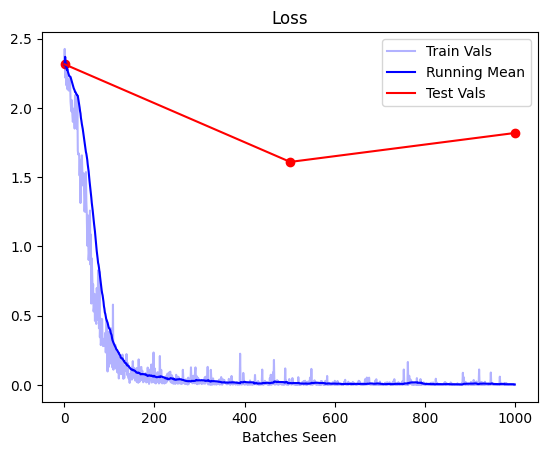

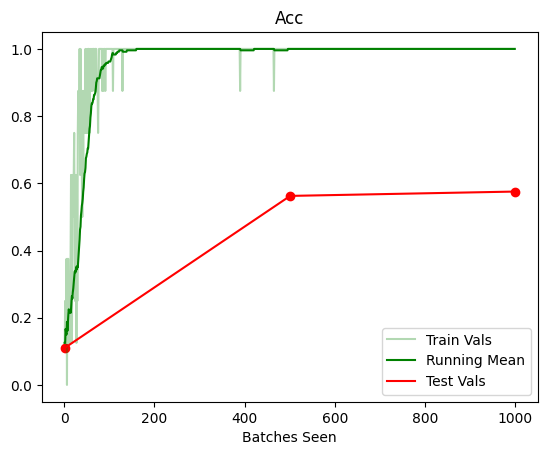

Evaluating network performance on MNIST with 4 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


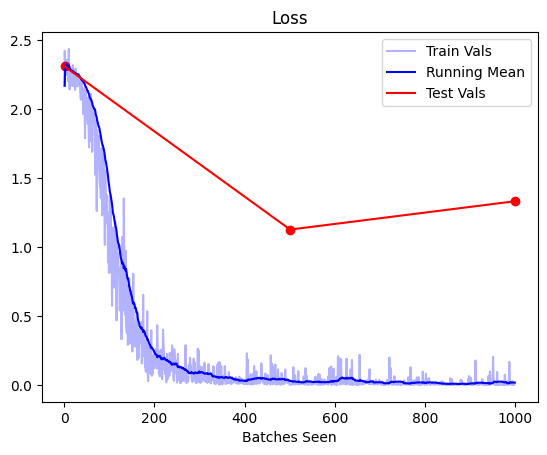

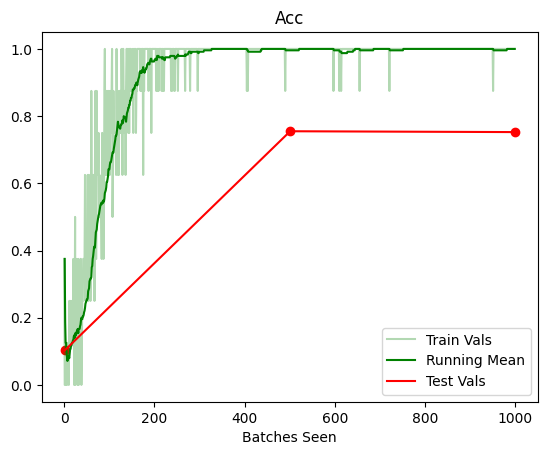

Evaluating network performance on MNIST with 16 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


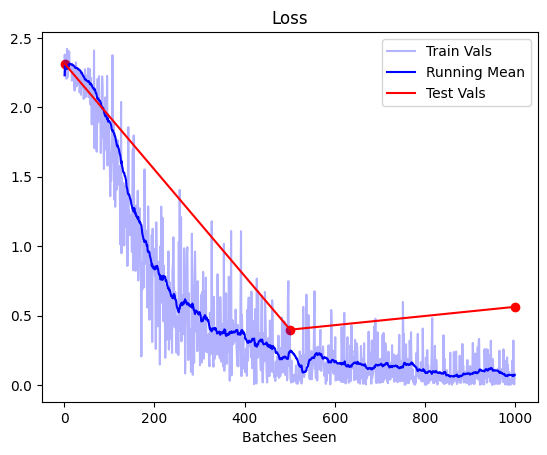

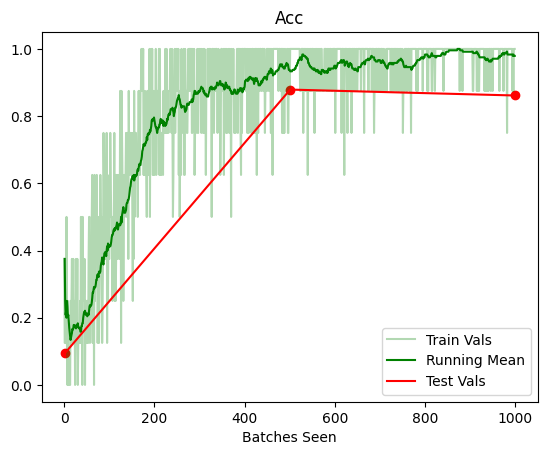

Evaluating network performance on MNIST with 64 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


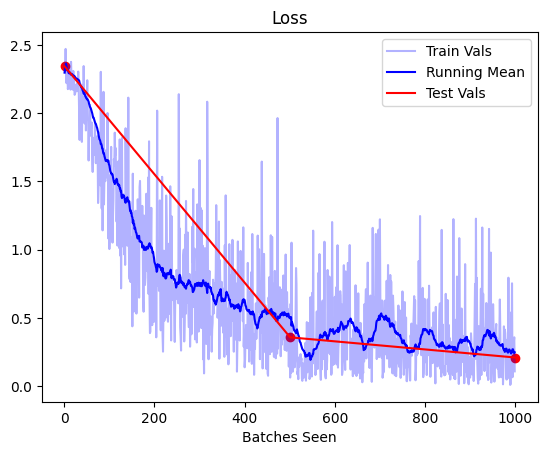

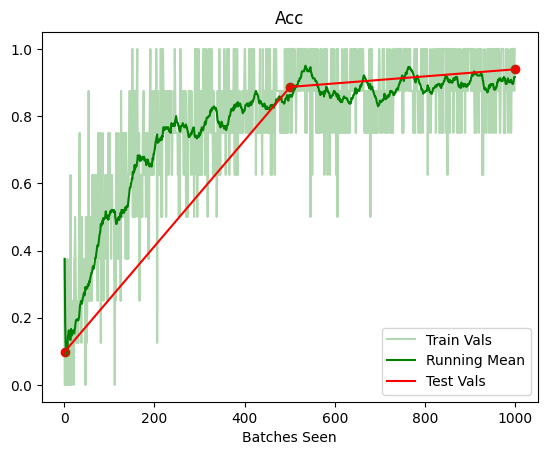

In [12]:
# How does MNIST performance get affected by the size of the training set?
for samples_per_class in [1, 4, 16, 64]:
    print('Evaluating network performance on MNIST with {} samples per class:'.format(samples_per_class))
    full_network = Net()
    optimizer = optim.SGD(full_network.parameters(), lr=0.01)
    _, _, _, _ = train(
        full_network,
        full_network.forward,
        optimizer,
        augmentation=None,
        transform=None,
        n_batches=1000,
        train_dataset=subsampled_mnists[samples_per_class],
        test_dataset=test_mnist_data
    )
    print()

Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


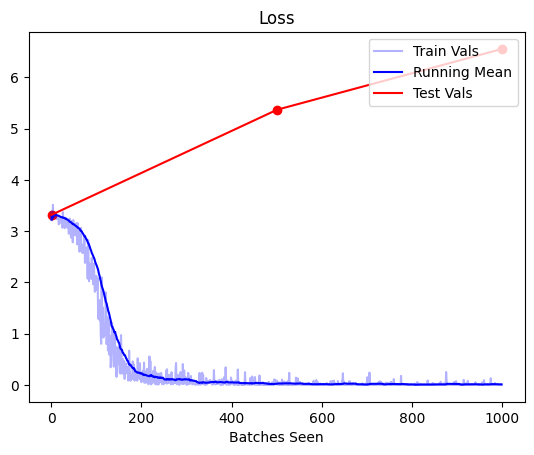

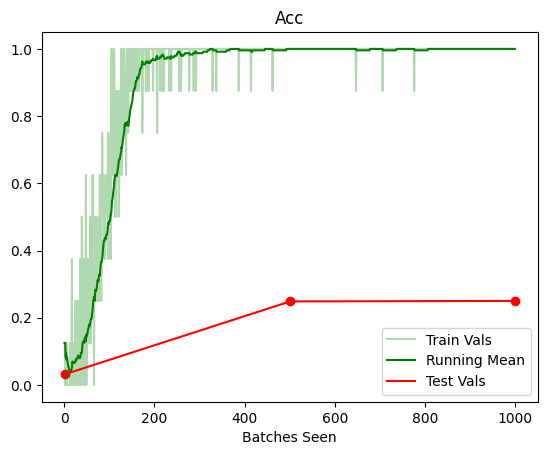

Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


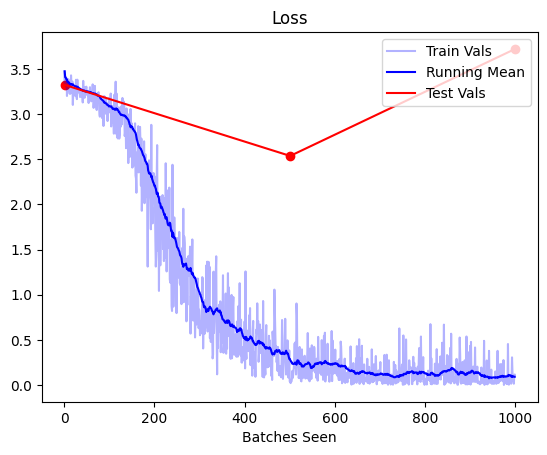

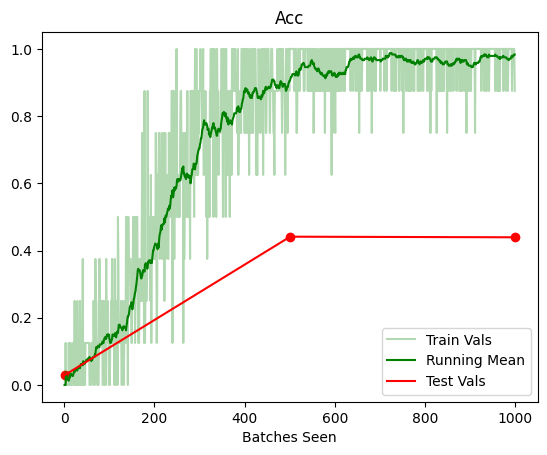

Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


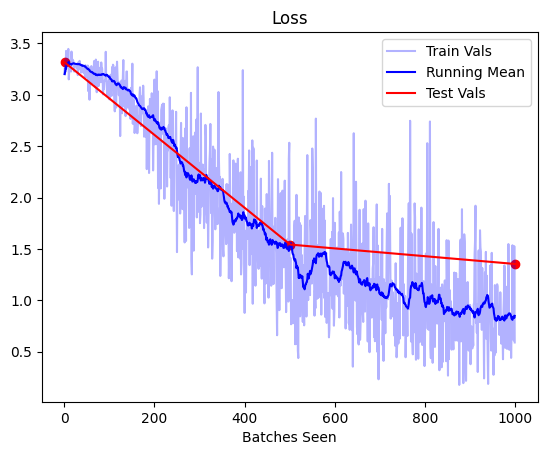

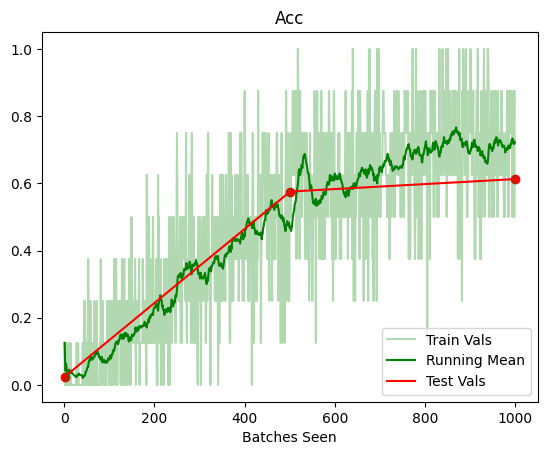

Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


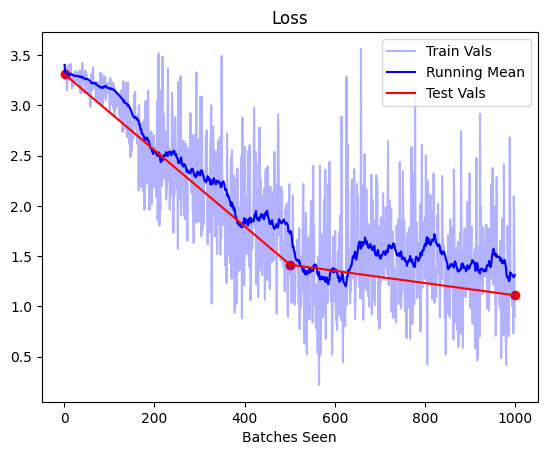

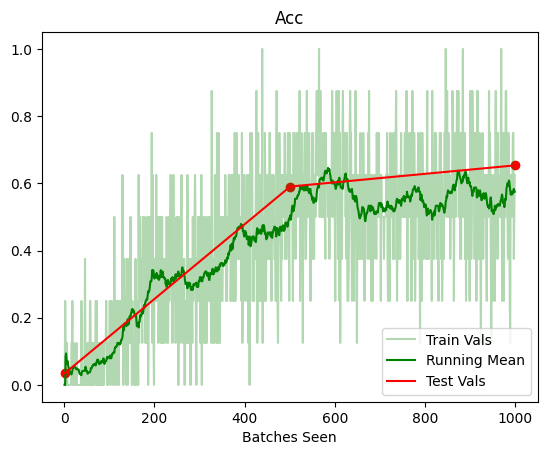

[[0.03159341 0.2485015  0.25      ]
 [0.02934565 0.4411838  0.43935645]
 [0.02447552 0.5755494  0.61262375]
 [0.03459041 0.5904096  0.65346533]]


In [10]:
# How does EMNIST performance get affected by the size of the training set?
all_test_accs = []
for samples_per_class in [1, 4, 16, 64]:
    print('Evaluating network performance on EMNIST with {} samples per class'.format(samples_per_class))
    full_network = Net()
    optimizer = optim.SGD(full_network.parameters(), lr=0.01)
    _, _, _, test_accs = train(
        full_network,
        full_network.generalize,
        optimizer,
        augmentation=None,
        transform=None,
        n_batches=1000,
        train_dataset=subsampled_emnists[samples_per_class],
        test_dataset=test_emnist_data,
        test_forward_call=full_network.generalize
    )
    all_test_accs.append(test_accs)
    print()
    
all_test_accs = np.squeeze(np.array(all_test_accs))
print(all_test_accs)

What if we pre-train the network to discern augmented images from non-augmented ones?
Pre-training...
Testing at batch 0 of 10000...
Testing at batch 500 of 10000...
Testing at batch 1000 of 10000...
Testing at batch 1500 of 10000...
Testing at batch 2000 of 10000...
Testing at batch 2500 of 10000...
Testing at batch 3000 of 10000...
Testing at batch 3500 of 10000...
Testing at batch 4000 of 10000...
Testing at batch 4500 of 10000...
Testing at batch 5000 of 10000...
Testing at batch 5500 of 10000...
Testing at batch 6000 of 10000...
Testing at batch 6500 of 10000...
Testing at batch 7000 of 10000...
Testing at batch 7500 of 10000...
Testing at batch 8000 of 10000...
Testing at batch 8500 of 10000...
Testing at batch 9000 of 10000...
Testing at batch 9500 of 10000...
Finished training. Computing final test set statistics...


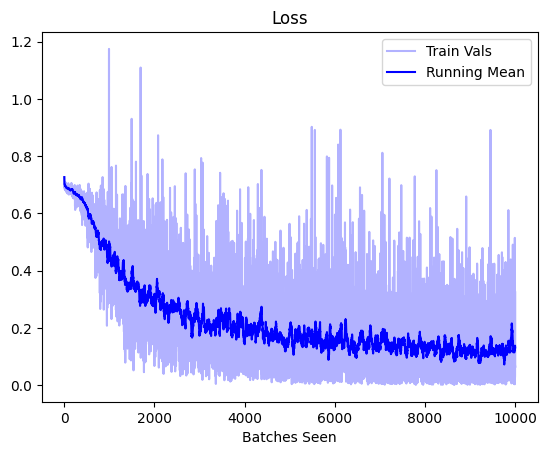

Evaluating pre-trained network performance on EMNIST with 1 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


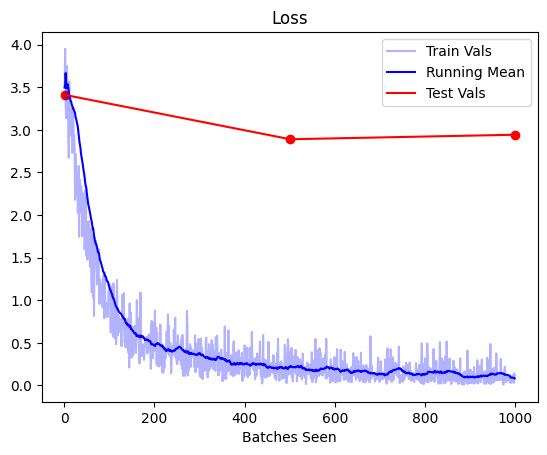

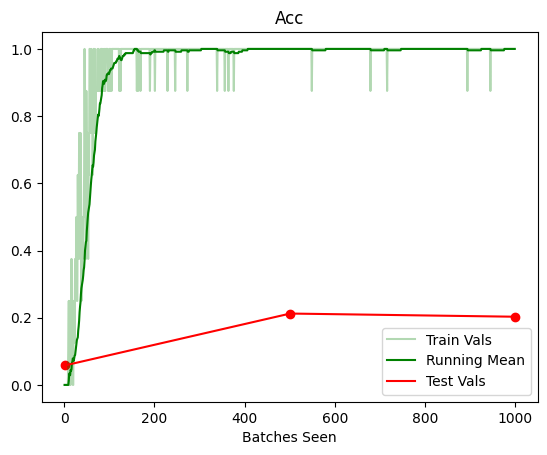


Evaluating pre-trained network performance on EMNIST with 4 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


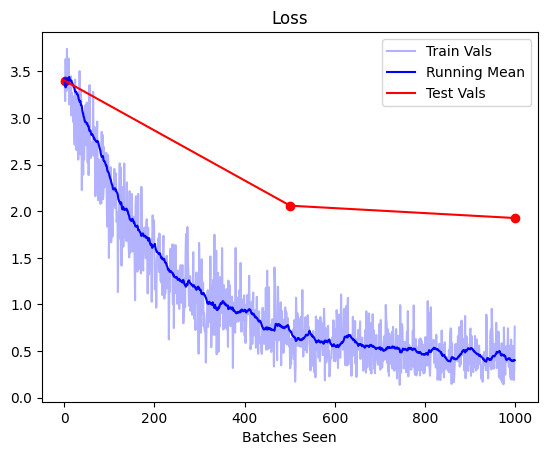

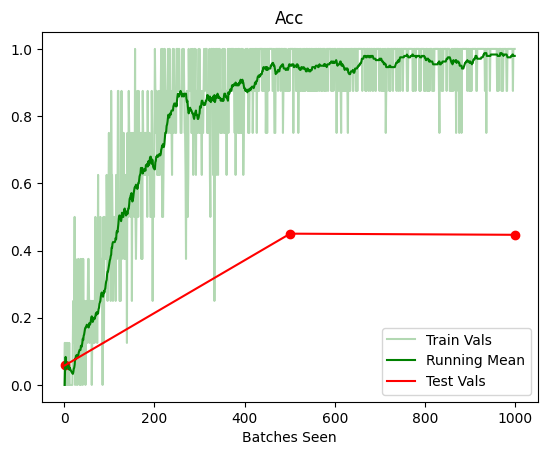


Evaluating pre-trained network performance on EMNIST with 16 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


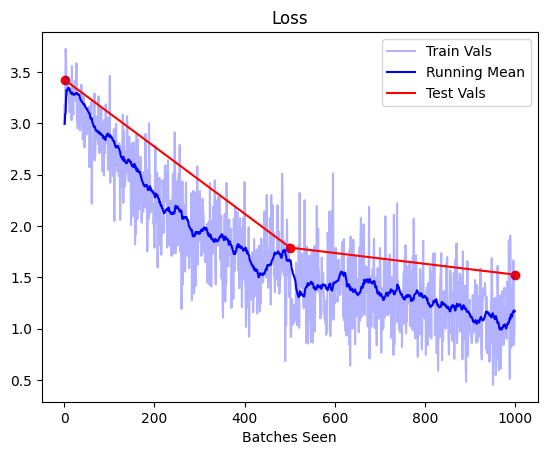

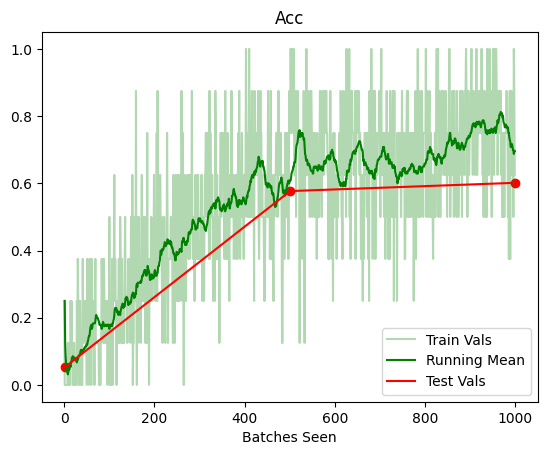


Evaluating pre-trained network performance on EMNIST with 64 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


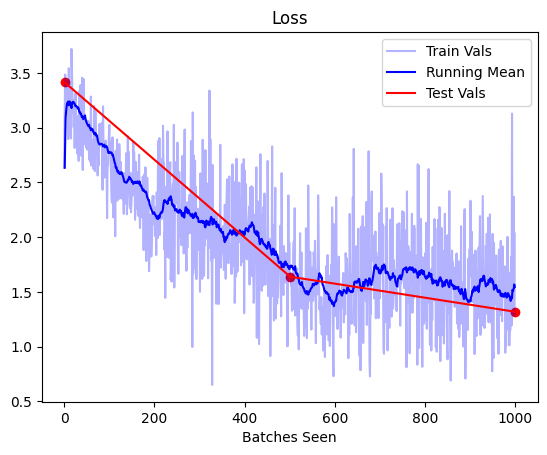

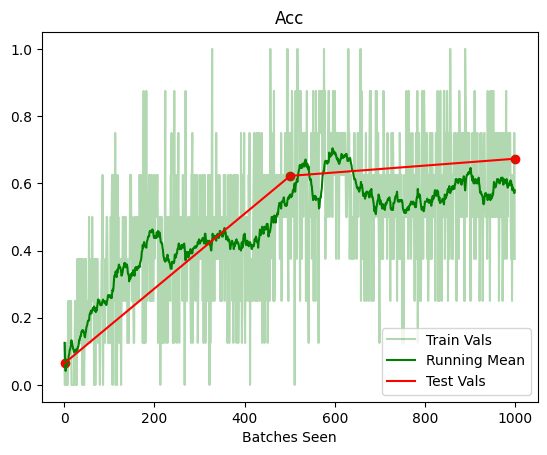


[[0.05794206 0.21241258 0.2029703 ]
 [0.05794206 0.45017484 0.44678217]
 [0.05257243 0.5769231  0.60148513]
 [0.06518482 0.6221279  0.6732673 ]]


In [14]:
# Do unsupervised pre-training and then train EMNIST classifier
all_unsup_test_accs = []
full_network = Net()
optimizer = optim.SGD(full_network.parameters(), lr=0.01)
print('What if we pre-train the network to discern augmented images from non-augmented ones?')
print('Pre-training...')
_, _, _, _ = train(
    full_network,
    full_network.decide_orig,
    optimizer,
    unsupervised=True,
    augmentation=collage,
    transform=gaussian_blur,
    n_batches=10000
)
for samples_per_class in [1, 4, 16, 64]:
    print('Evaluating pre-trained network performance on EMNIST with {} samples per class'.format(samples_per_class))
    network_copy = deepcopy(full_network)
    optimizer = optim.SGD(network_copy.generalizer.parameters(), lr=0.01)
    unsup_losses, unsup_accs, unsup_test_losses, unsup_test_accs = train(
        network_copy,
        network_copy.generalize,
        optimizer,
        augmentation=None,
        transform=None,
        train_dataset=subsampled_emnists[samples_per_class],
        test_dataset=test_emnist_data,
        test_forward_call=network_copy.generalize,
        n_batches=1000
    )
    all_unsup_test_accs.append(unsup_test_accs)
    print()

all_unsup_test_accs = np.squeeze(np.array(all_unsup_test_accs))
print(all_unsup_test_accs)

Now pre-training the network on standard MNIST...
Testing at batch 0 of 10000...
Testing at batch 500 of 10000...
Testing at batch 1000 of 10000...
Testing at batch 1500 of 10000...
Testing at batch 2000 of 10000...
Testing at batch 2500 of 10000...
Testing at batch 3000 of 10000...
Testing at batch 3500 of 10000...
Testing at batch 4000 of 10000...
Testing at batch 4500 of 10000...
Testing at batch 5000 of 10000...
Testing at batch 5500 of 10000...
Testing at batch 6000 of 10000...
Testing at batch 6500 of 10000...
Testing at batch 7000 of 10000...
Testing at batch 7500 of 10000...
Testing at batch 8000 of 10000...
Testing at batch 8500 of 10000...
Testing at batch 9000 of 10000...
Testing at batch 9500 of 10000...
Finished training. Computing final test set statistics...


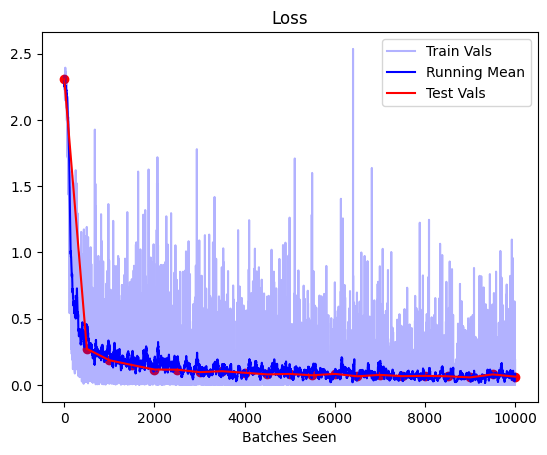

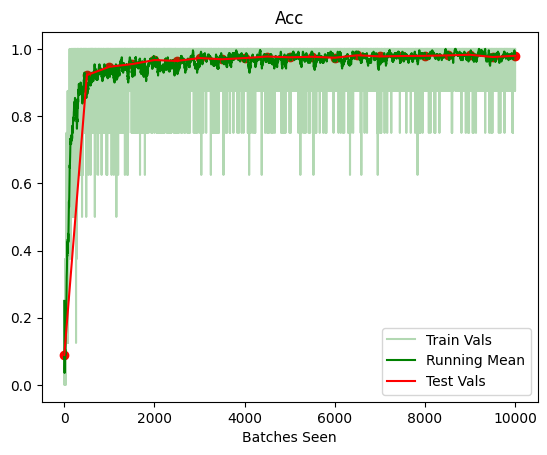

Evaluating pre-trained network performance on EMNIST with 1 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


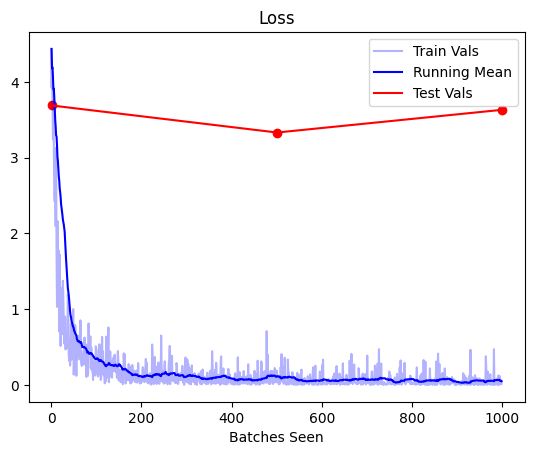

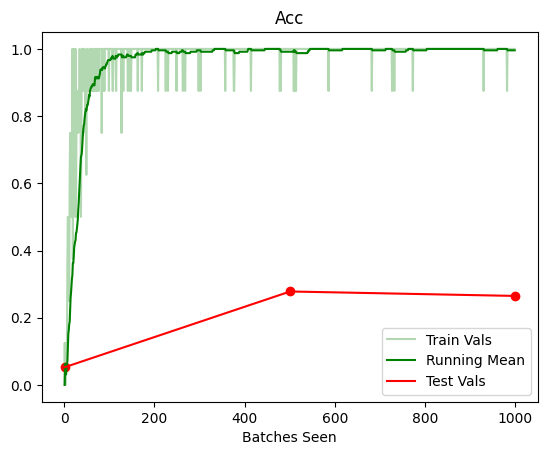


Evaluating pre-trained network performance on EMNIST with 4 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


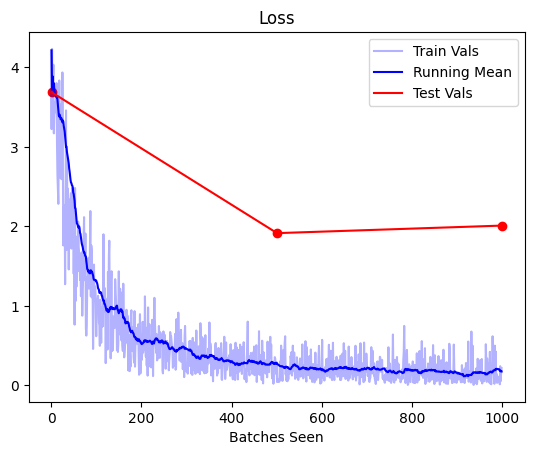

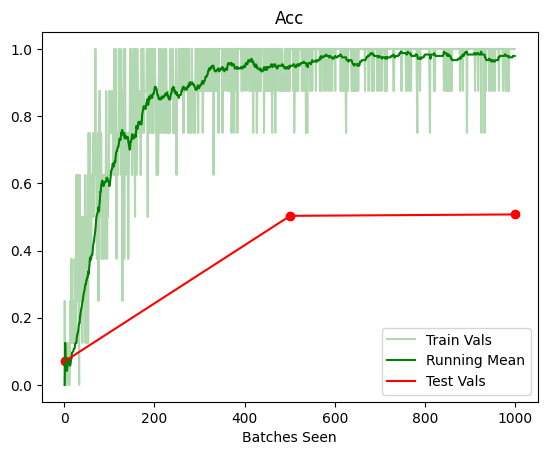


Evaluating pre-trained network performance on EMNIST with 16 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


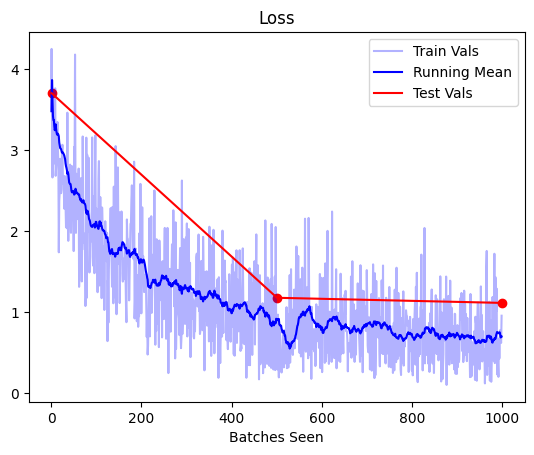

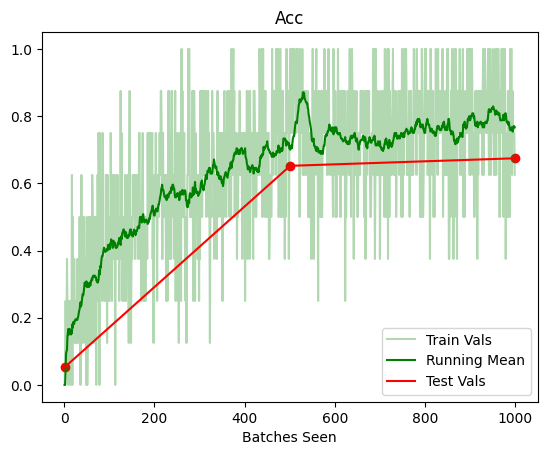


Evaluating pre-trained network performance on EMNIST with 64 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


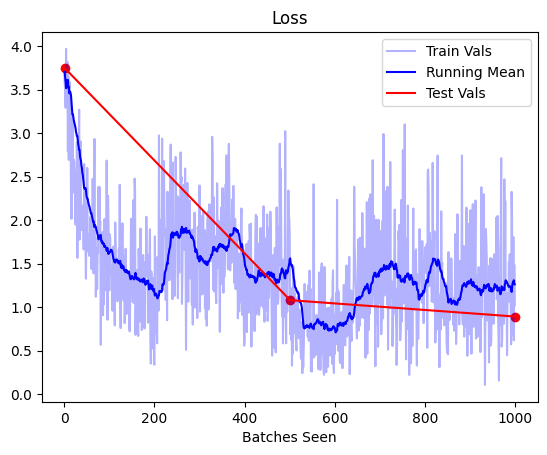

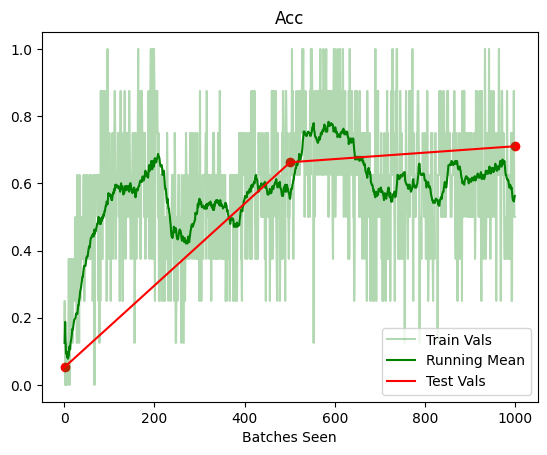


[[[0.0526973  0.2780969  0.26485148]]

 [[0.07042957 0.5032467  0.5074257 ]]

 [[0.05282218 0.6520979  0.67450494]]

 [[0.05332168 0.6627123  0.71039605]]]


In [15]:
# Train on regular MNIST
all_reg_test_accs = []
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01)
print('Now pre-training the network on standard MNIST...')
_, _, _, _ = train(
    network,
    network.forward,
    optimizer,
    augmentation=None,
    transform=None,
    n_batches=10000
)
for samples_per_class in [1, 4, 16, 64]:
    print('Evaluating pre-trained network performance on EMNIST with {} samples per class'.format(samples_per_class))
    network_copy = deepcopy(network)
    optimizer = optim.SGD(network_copy.generalizer.parameters(), lr=0.01)
    _, _, _, reg_test_accs = train(
        network_copy,
        network_copy.generalize,
        optimizer,
        augmentation=None,
        transform=None,
        train_dataset=subsampled_emnists[samples_per_class],
        test_dataset=test_emnist_data,
        test_forward_call=network_copy.generalize,
        n_batches=1000
    )
    all_reg_test_accs.append(reg_test_accs)
    print()
    
all_reg_test_accs = np.array(all_reg_test_accs)
print(all_reg_test_accs)


Finally, pre-train the network on the MNIST dataset with interpolated classes...
Testing at batch 0 of 10000...
Testing at batch 500 of 10000...
Testing at batch 1000 of 10000...
Testing at batch 1500 of 10000...
Testing at batch 2000 of 10000...
Testing at batch 2500 of 10000...
Testing at batch 3000 of 10000...
Testing at batch 3500 of 10000...
Testing at batch 4000 of 10000...
Testing at batch 4500 of 10000...
Testing at batch 5000 of 10000...
Testing at batch 5500 of 10000...
Testing at batch 6000 of 10000...
Testing at batch 6500 of 10000...
Testing at batch 7000 of 10000...
Testing at batch 7500 of 10000...
Testing at batch 8000 of 10000...
Testing at batch 8500 of 10000...
Testing at batch 9000 of 10000...
Testing at batch 9500 of 10000...
Finished training. Computing final test set statistics...


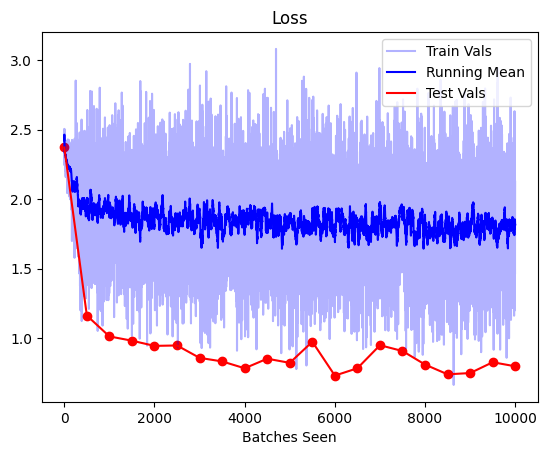

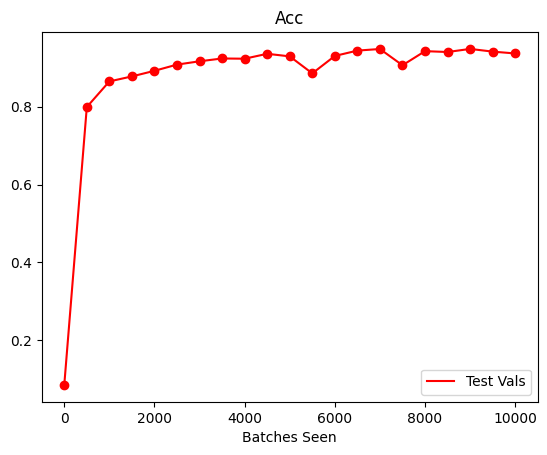


Evaluating pre-trained network performance on EMNIST with 1 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


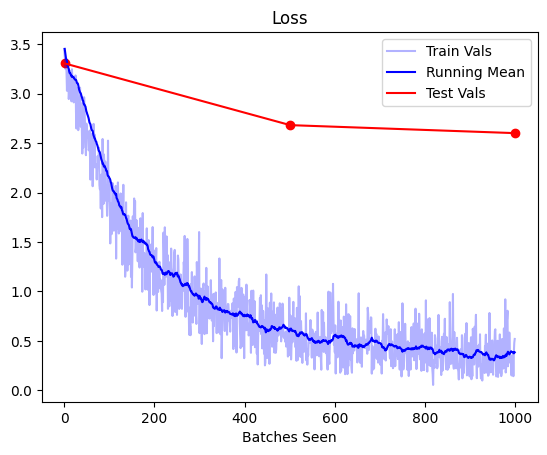

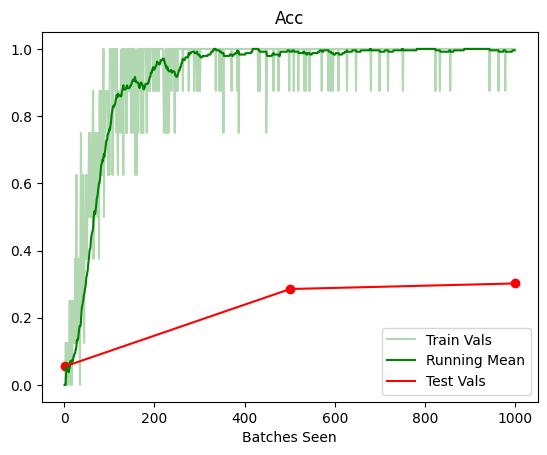


Evaluating pre-trained network performance on EMNIST with 4 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


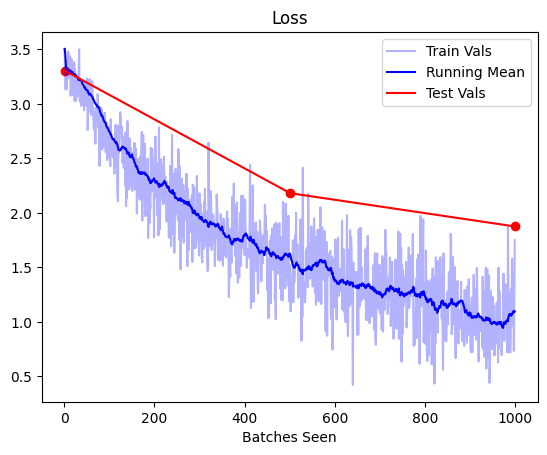

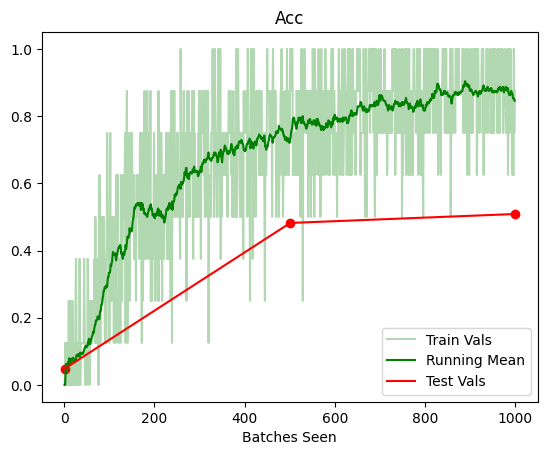


Evaluating pre-trained network performance on EMNIST with 16 samples per class
Testing at batch 0 of 1000...
Testing at batch 500 of 1000...
Finished training. Computing final test set statistics...


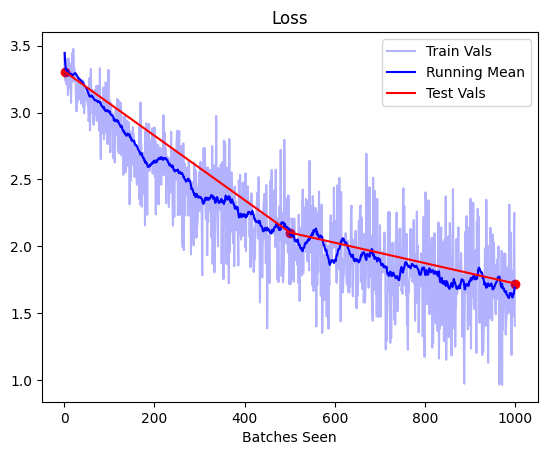

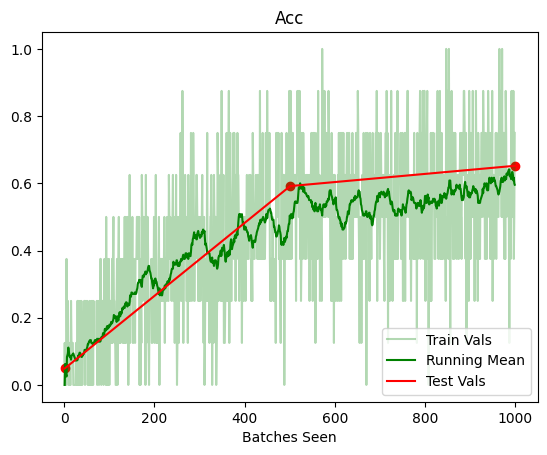


Evaluating pre-trained network performance on EMNIST with 64 samples per class
Testing at batch 0 of 1000...


In [ ]:
# Now do mixup and collage with the interpolated classes
def floating_point_nll_loss(pred, target):
    log_likelihoods = -pred * target
    return torch.mean(torch.sum(log_likelihoods, dim=-1))

all_semisup_test_accs = []
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01)
print('Finally, pre-train the network on the MNIST dataset with interpolated classes...')
_, _, _, _ = train(
    network,
    network.forward,
    optimizer,
    semisupervised=True,
    obj_func=floating_point_nll_loss,
    augmentation=mixup,
    transform=None,
    n_batches=10000
)
print()
for samples_per_class in [1, 4, 16, 64]:
    print('Evaluating pre-trained network performance on EMNIST with {} samples per class'.format(samples_per_class))
    network_copy = deepcopy(network)
    optimizer = optim.SGD(network_copy.generalizer.parameters(), lr=0.01)
    semisup_losses, semisup_accs, semisup_test_losses, semisup_test_accs = train(
        network_copy,
        network_copy.generalize,
        optimizer,
        augmentation=None,
        transform=None,
        train_dataset=subsampled_emnists[samples_per_class],
        test_dataset=test_emnist_data,
        test_forward_call=network_copy.generalize,
        n_batches=1000
    )
    all_semisup_test_accs.append(semisup_test_accs)
    print()

all_semisup_test_accs = np.array(all_semisup_test_accs)
print(all_semisup_test_accs)

In [ ]:
# Then do the same thing but training simultaneously on unsupervised/semisupervised task and on EMNIST